# Домашнеее задание: Июльский курс (2020). Pro. Занятие 22
# Интеграция в Production. Часть 2
## Верхошинская Катерина Викторовна

## **LIGHT**

### Задание

1. Поставить TF Serving на свой ПК, используя docker (Windows: https://docs.docker.com/docker-for-windows/install/ ; Mac: https://docs.docker.com/docker-for-mac/install/; CentOS: https://docs.docker.com/install/linux/docker-ce/centos/ -см другие дистрибутивы Linux по ссылке https://docs.docker.com/install/linux/docker-ce/ )
2. Обучить модель cifar10 Keras, сохранить в формат SavedModel
3. Вывести сигнатуру для сконвертированной модели
4. Запустить Tensor flow serving, используя docker, указав путь к модели
5. Написать любую функцию используя numpy, переписать функцию, используя numba (@jit decorator), таким образом чтобы версия numba работала быстрее. 


#### 1) Поставить TF Serving на свой ПК, используя docker

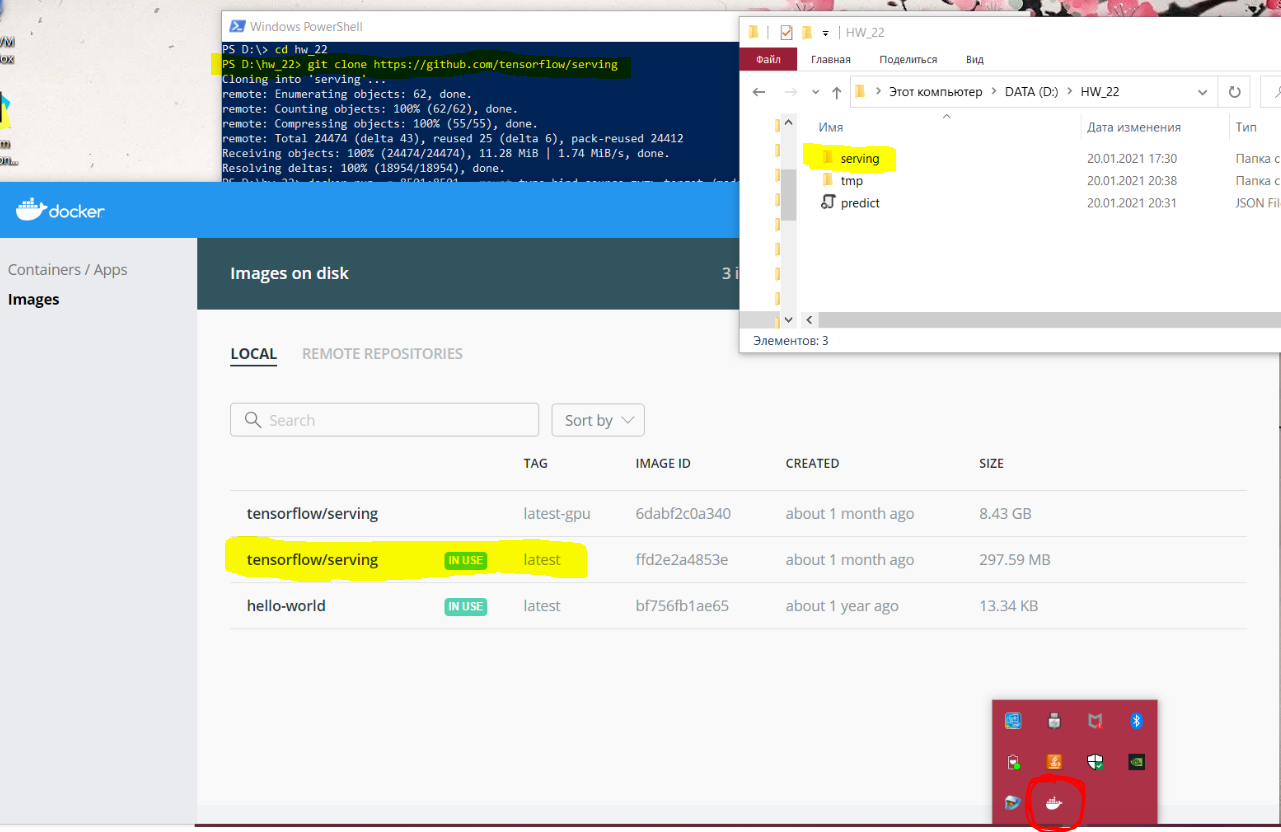

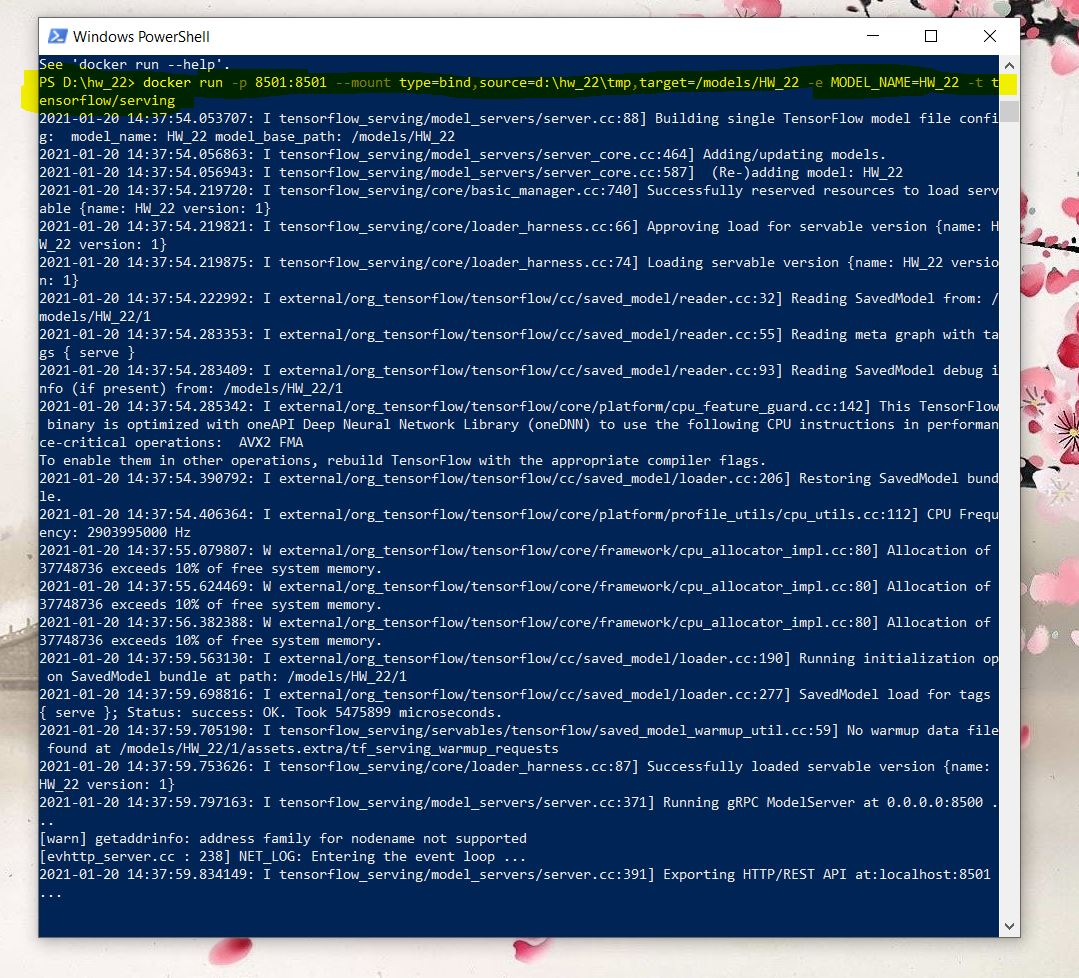

#### 2) Обучить модель cifar10 Keras, сохранить в формат SavedModel

In [ ]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
import tempfile
import matplotlib.pyplot as plt
import os
# будем отслеживать все ошибки
import subprocess
import random
import numpy as np
from PIL import Image

# Посмотрим на текущую версиб ТФ
print(tf.__version__)

2.4.0


In [ ]:
#Загружаем cifar10
from tensorflow.keras.datasets import cifar10  #Загружаем базу cifar10
(x_train10, y_train10), (x_test10, y_test10) = cifar10.load_data()

# Определяем названия классов по порядку
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

# Превращаем y_train и y_test в формат one hot encoding
y_train10 = utils.to_categorical(y_train10, 10)
y_test10 = utils.to_categorical(y_test10, 10)


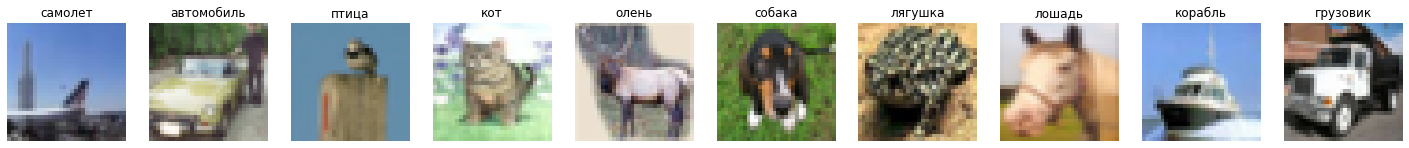

In [ ]:
# Выводим для примера картинки по каждому классу
fig, axs = plt.subplots(1, 10, figsize=(25, 3))
for i in range(10):
  label_indexes = np.where(y_train10==i)[0]
  index = random.choice(label_indexes)
  img = x_train10[index]
  axs[i].imshow(Image.fromarray(img))
  axs[i].axis('off')
  axs[i].set_title(classes[i])

plt.show()

In [ ]:
# Нормализуем значения пикселей до интервала от 0 до 1
x_train10 = x_train10 / 255.0
x_test10 = x_test10 / 255.0

# Приводим к виду 4D тензора
x_train10 = x_train10.reshape(x_train10.shape[0], 32, 32, 3)
x_test10 = x_test10.reshape(x_test10.shape[0], 32, 32, 3)

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(32, 32, 3), filters=8, kernel_size=3, strides=2, activation='relu', name='Conv1'))
model.add(Flatten())
model.add(Dense(10, activation=tf.nn.softmax, name='Softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 15, 15, 8)         224       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                18010     
Total params: 18,234
Trainable params: 18,234
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train10, y_train10, epochs=50)

test_loss, test_acc = model.evaluate(x_test10, y_test10)
print('\nТочность на проверке: {}'.format(test_acc))

Epoch 1/50
1563/1563 [==============================] - 4s 2ms/step - loss: 1.1771 - accuracy: 0.5899
Epoch 2/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1588 - accuracy: 0.5967
Epoch 3/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1566 - accuracy: 0.5952
Epoch 4/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1609 - accuracy: 0.5951
Epoch 5/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1564 - accuracy: 0.6002
Epoch 6/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1435 - accuracy: 0.5991
Epoch 7/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1425 - accuracy: 0.6008
Epoch 8/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1378 - accuracy: 0.6025
Epoch 9/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1400 - accuracy: 0.6019
Epoch 10/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.134

##### Сохраняем модель



In [ ]:
MODEL_DIR = '/content/our_models1'# создание временной директории для хранения модели
version = 1  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = /content/our_models1/1



In [ ]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}


Модель уже сохранена



In [ ]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /content/our_models1/1/assets

Сохраненная модель:
total 88
drwxr-xr-x 2 root root  4096 Jan 23 19:54 assets
-rw-r--r-- 1 root root 79493 Jan 23 19:54 saved_model.pb
drwxr-xr-x 2 root root  4096 Jan 23 19:54 variables


#### 3) Вывести сигнатуру для сконвертированной модели

Используем утилиту терминала `saved_model_cli` для того, чтобы взглянуть на [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (модели) и [SignatureDefs](../signature_defs) (методы, которые вы можете вызвать) сохраненной модели.


Выведем информацию о модели. В случае, если бы не были известны inputs\outputs, то подпись могла бы нам это показать, как и в этом случае, когда нам все известно.


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0123 19:55:08.820843 140024905353088 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pytho

#### 4) Запустить Tensor flow serving, используя docker, указав путь к модели

сначало в Jupyter Notebook

##### Используем TensorFlow Serving для обслуживания модели


In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  22127      0 --:--:-- --:--:-- --:--:-- 22127
OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launc

##### Установка TensorFlow Serving

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.4.0).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


##### Запускаем TensorFlow Serving

После того, как мы запустим TFS и загрузим модель, можно начать делать инференс-запросы, используя [REST](https://ru.wikipedia.org/wiki/REST). Одни из наиболее важных параметров: 

* `rest_api_port`: Этот порт используется для REST запросов.
* `model_name`: Его вы будете использовать для URL REST запросов. Любой псевдоним.
* `model_base_path`: Это путь к расположению вашей модели. 


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


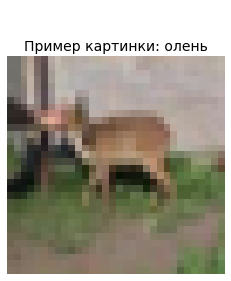

In [ ]:
# Функция для просмотра картинки из сета
def show(x_test10, idx, title):
  plt.figure()
  plt.imshow(x_test10[idx])
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 14})

rando = random.randint(0, len(x_test10) - 1)
show(x_test10, rando, 'Пример картинки: {}'.format(classes[y_test10[rando][0]]))

##### Создаем запрос к модели в TensorFlow Serving





Создаем REST запрос

Создаем JSON объект для batch-а 3х инференс-запросов и посмотрим, насколько хорошо модель распознает вещи

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test10[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... ], [25, 31, 37], [5, 6, 8], [4, 5, 3], [7, 8, 7]]]]}


Обновленная версия servable/обслуживаемой модели

Пошлем запрос с помощью POST на конечную точку нашего REST сервера и передадим ему 3 образца. Также запросим у сервера последнюю версю обслуживаемой модели, не указывая  конкретно ее версию. 

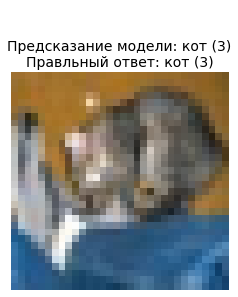

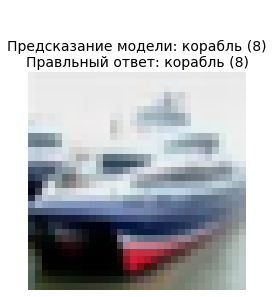

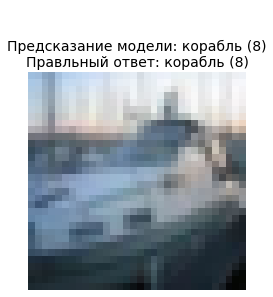

In [ ]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/cifar10:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(3):
  show(x_test10, i,
       'Предсказание модели: {} ({})\nПравльный ответ: {} ({})'
       .format(classes[np.argmax(predictions[i])], np.argmax(predictions[i]),
               classes[y_test10[i][0]], y_test10[i][0]))


In [ ]:
len(predictions)

3

In [ ]:
print(json_response.text)

{
    "predictions": [[0.0213636775, 0.0179181788, 0.0303447358, 0.468413174, 0.0252478868, 0.171168759, 0.132017583, 0.0642642826, 0.00487663364, 0.0643850416], [0.00154119369, 0.0113717318, 2.67809469e-07, 1.80256137e-07, 1.13754328e-09, 3.09133164e-09, 7.51009225e-07, 3.15604476e-09, 0.986291111, 0.000794750056], [0.0612559021, 0.206173599, 0.0468882136, 0.0730993822, 0.00799961, 0.029762242, 0.00933794, 0.0763877779, 0.330824316, 0.158270895]
    ]
}


Сохраняем модель

In [ ]:
!zip -r '/content/model.zip' '/content/our_models1'

  adding: content/our_models1/ (stored 0%)
  adding: content/our_models1/1/ (stored 0%)
  adding: content/our_models1/1/assets/ (stored 0%)
  adding: content/our_models1/1/variables/ (stored 0%)
  adding: content/our_models1/1/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/our_models1/1/variables/variables.index (deflated 75%)
  adding: content/our_models1/1/saved_model.pb (deflated 90%)
  adding: content/our_models1/2/ (stored 0%)
  adding: content/our_models1/2/assets/ (stored 0%)
  adding: content/our_models1/2/variables/ (stored 0%)
  adding: content/our_models1/2/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/our_models1/2/variables/variables.index (deflated 75%)
  adding: content/our_models1/2/saved_model.pb (deflated 90%)


In [ ]:
json_file = open('predict.json', 'w')
json_file.write(data)
json_file.close()

после этого, имея модель и предикт можно запустить локально на ПК

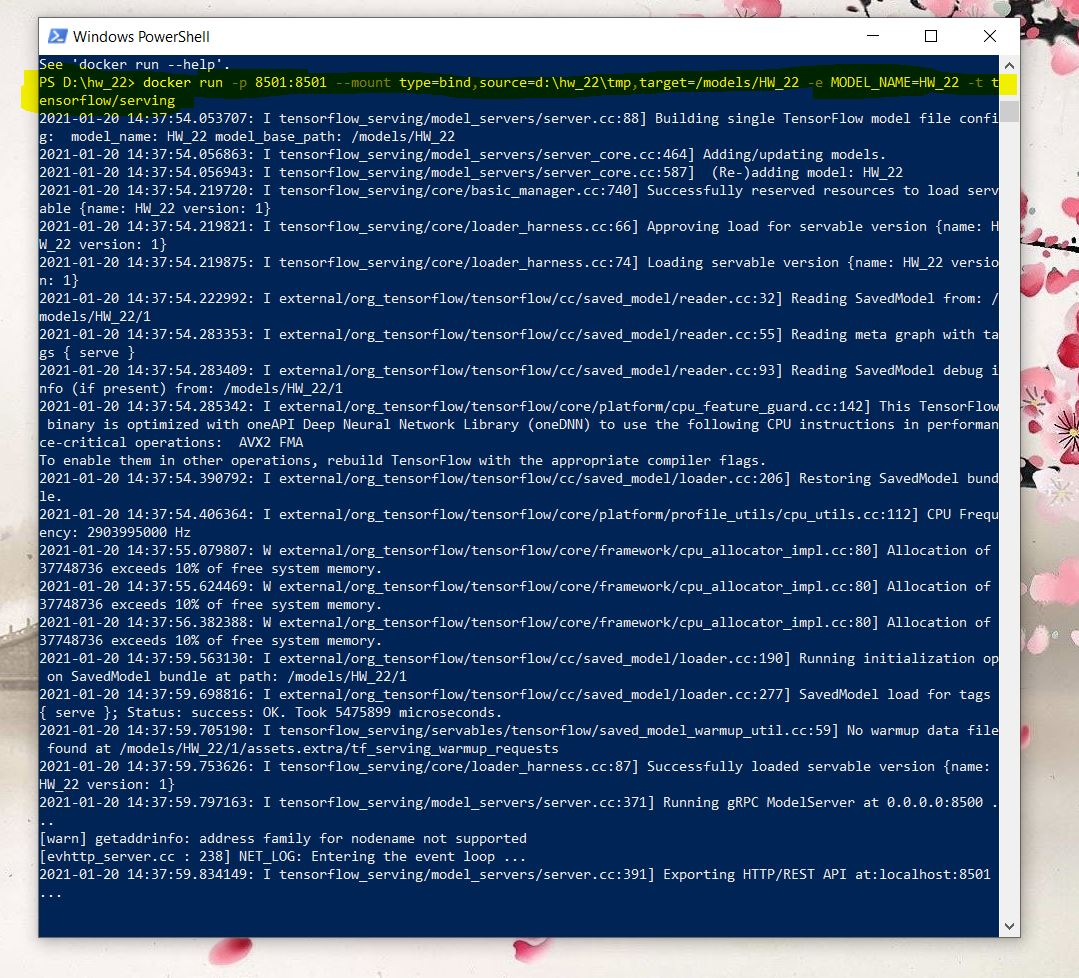

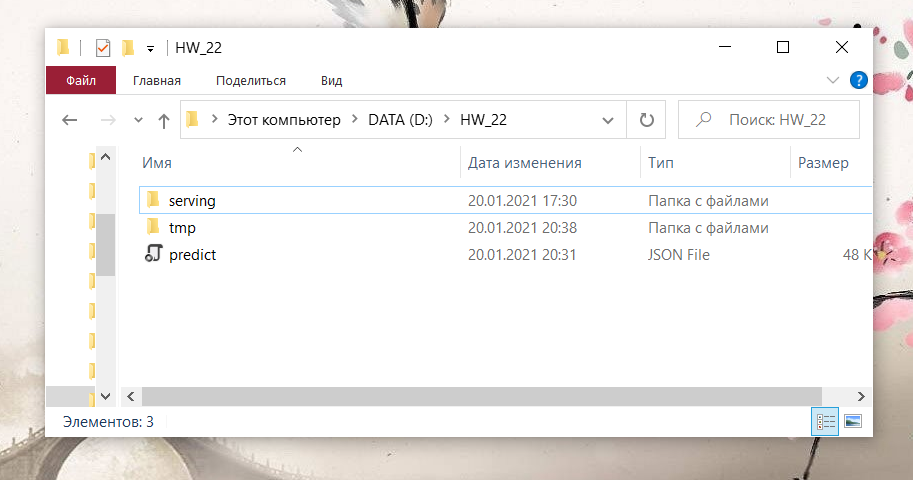

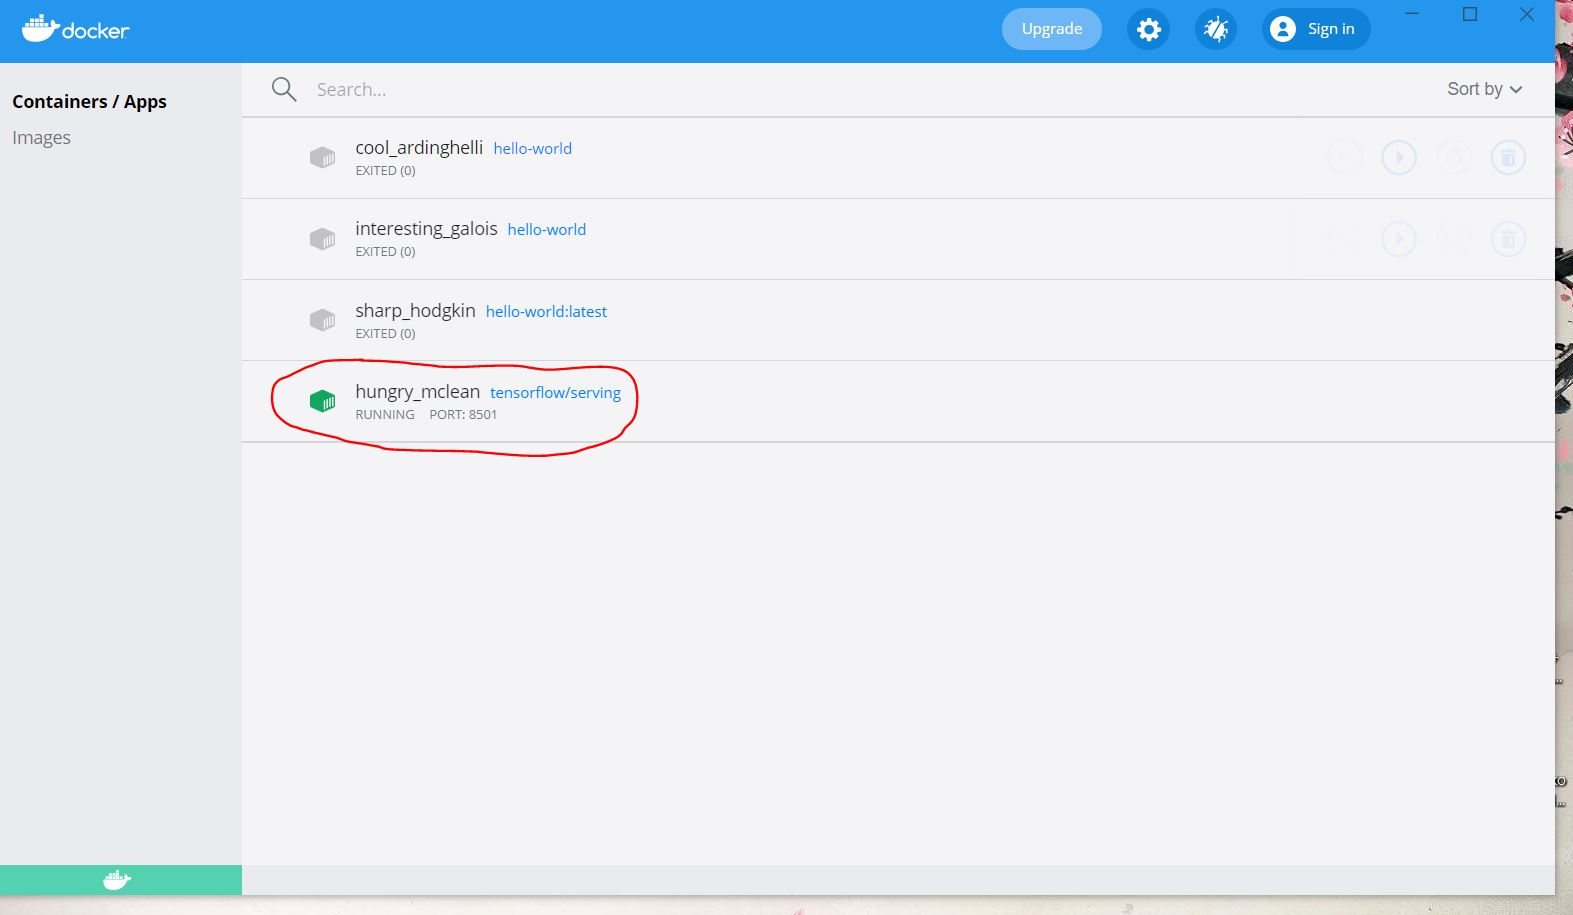

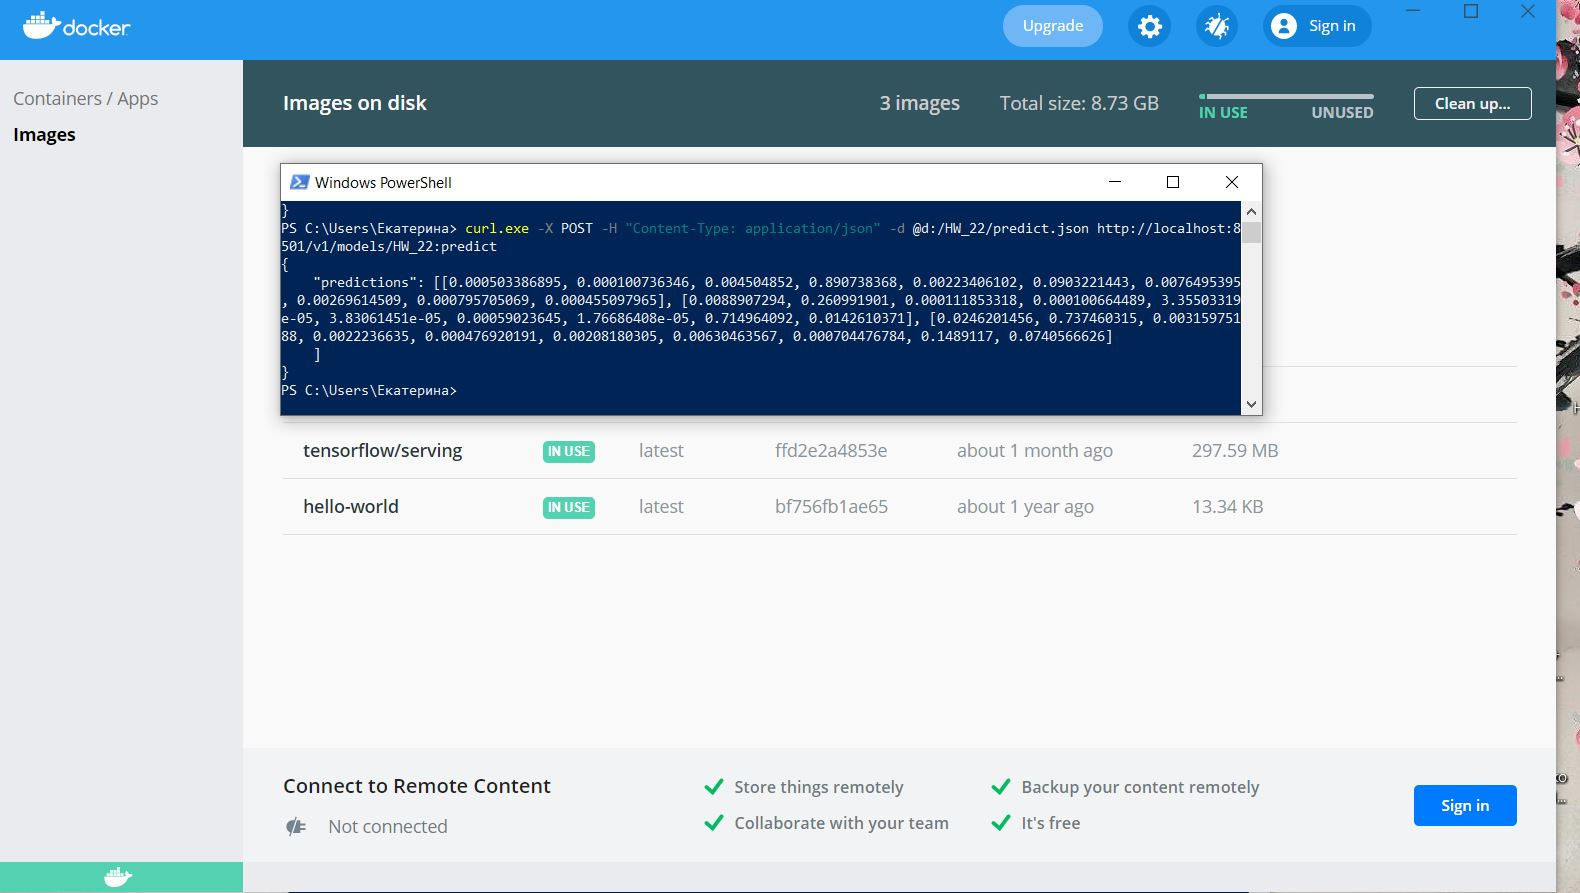

#### 5) Написать любую функцию используя numpy, переписать функцию, используя numba (@jit decorator), таким образом чтобы версия numba работала быстрее.

In [ ]:
import numpy as np

Z = np.arange(100)
v = np.random.uniform(0,100)

#функция находит ближайшее к заданному значению число в заданном массиве
def test_numpy(Z,v):
  index = (np.abs(Z-v)).argmin()
  return Z[index] 

test_numpy(Z,v)  

63

In [ ]:
import time

#Используем чистый python
cur_time = time.time()
%timeit test_numpy(Z,v)
print('time without NUMBA: ', time.time()-cur_time)

The slowest run took 20.40 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.34 µs per loop
time without NUMBA:  1.003479242324829


In [ ]:
from numba import jit 

# Используем Numba декоратор с включенным компилятором
@jit(nopython=True)
def test_numba(Z,v):
  index = (np.abs(Z-v)).argmin()
  return Z[index]

In [ ]:
#Numba + Nopython режим
cur_time = time.time()
%timeit test_numba(Z,v)
print('time with NUMBA: ', time.time()-cur_time)

The slowest run took 399343.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 810 ns per loop
time with NUMBA:  0.3329493999481201


time without NUMBA:  1.003479242324829

time with NUMBA:  0.3329493999481201

Разница в быстроте работы налицо.

## **PRO**

### Задание

1. Поставить TF Serving на свой ПК, используя docker (Windows: https://docs.docker.com/docker-for-windows/install/ ; Mac: https://docs.docker.com/docker-for-mac/install/; CentOS: https://docs.docker.com/install/linux/docker-ce/centos/ -см другие дистрибутивы Linux по ссылке https://docs.docker.com/install/linux/docker-ce/ )
2. Обучите сеть на любой нестандартной керасовской базе данных
3. Сохраните несколько версий моделей в формате SavedModel
4. Создайте контейнер с изображением в docker, запустите сервер
5. Посмотрите каким будет предсказание для разных версий, используя запросы на сервер.
 


#### 1) Поставить TF Serving на свой ПК, используя docker

Данный пункт выполнен в задании LIGHT

#### 2) Обучите сеть на любой нестандартной керасовской базе данных + 3) Сохраните несколько версий моделей в формате SavedModel


In [ ]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
import tempfile
# будем отслеживать все ошибки
import subprocess
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import random #Для генерации случайных чисел 
import math # Для округления
import os #Для работы с файлами 
# подключем диск
from google.colab import drive

# Посмотрим на текущую версиб ТФ
print(tf.__version__)

2.4.0


База данных цветов "Flowers" была собрана собственноручно и включает в себя 3 класса по 200 изображений в каждом. Классы: герберы, розы, лилии. Дабы избежать заучивания по цветовой характеристики(например, если красный - значит роза), данные в базе подобранны максимально нормализованно - приблизительно равное количество цветков одного цвета в каждой из категорий.

In [ ]:
!unzip -q "/content/drive/My Drive/Flowers.zip" -d /content #Указываем путь к базе в Google Drive

In [ ]:
train_path = '/content/Flowers' #Папка с папками картинок, рассортированных по категориям
batch_size = 10 #Размер выборки
img_width = 100 #Ширина изображения
img_height = 100 #Высота изображения

In [ ]:
#Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, #Значения цвета меняем на дробные показания
    rotation_range=10, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=False, #Отключаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.17 #Указываем разделение изображений на обучающую и тестовую выборку
)

# обучающая выборка
train_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_height, img_width), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по виду растения
    shuffle=True, #Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_height, img_width), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по виду растения
    shuffle=True, #Перемешивание выборки
    subset='validation' # устанавливаем как валидационный набор
)


Found 498 images belonging to 3 classes.
Found 102 images belonging to 3 classes.


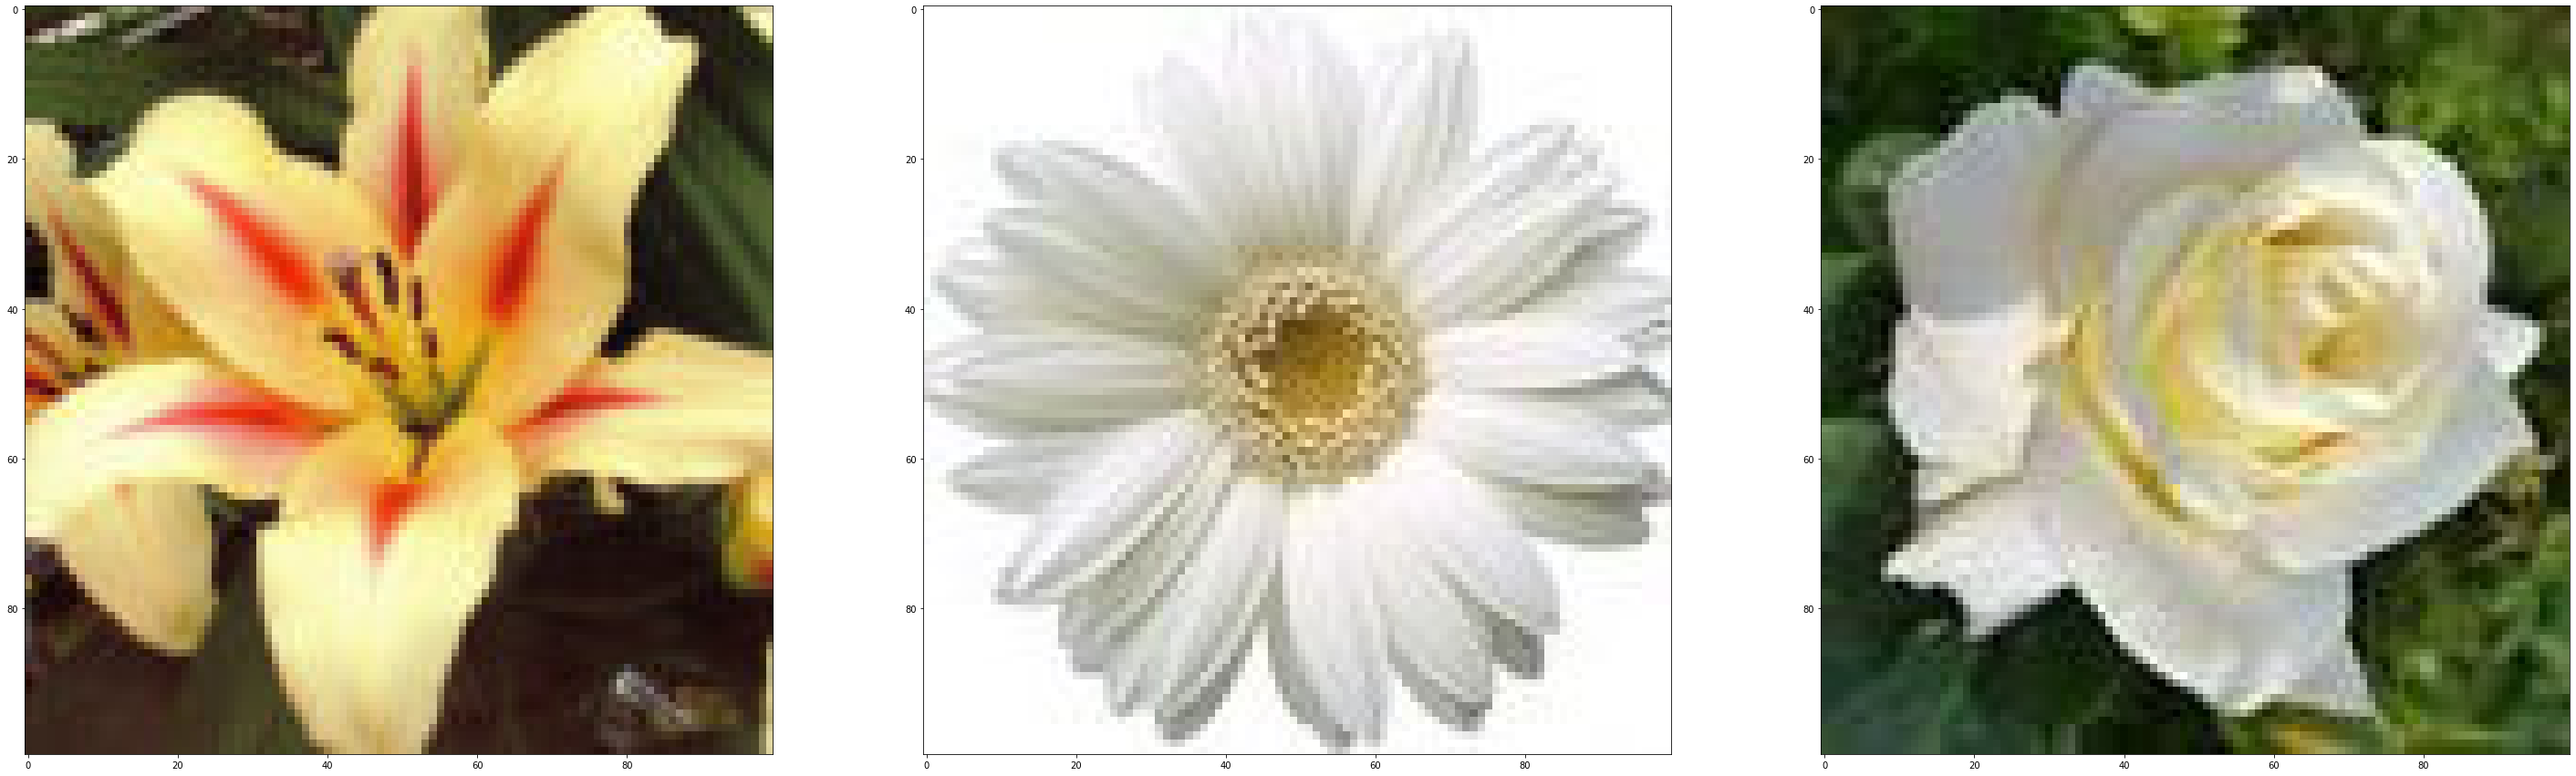

In [ ]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(50, 50)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  flowers_path = train_path + '/' + os.listdir(train_path)[i] + '/'#Формируем путь к выборке
  img_path = flowers_path + random.choice(os.listdir(flowers_path)) #Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии

plt.show() #Показываем изображения

##### Версия 1

In [ ]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
#model.add(Dropout(0.1))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(2048, activation='relu'))
#Полносвязный слой
model.add(Dense(4096, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              8

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=20,
    verbose=1
)

Epoch 1/20
49/49 [==============================] - 10s 48ms/step - loss: 1.0959 - accuracy: 0.3557 - val_loss: 1.0302 - val_accuracy: 0.5100
Epoch 2/20
49/49 [==============================] - 2s 43ms/step - loss: 1.0406 - accuracy: 0.4731 - val_loss: 0.9650 - val_accuracy: 0.6300
Epoch 3/20
49/49 [==============================] - 2s 43ms/step - loss: 0.9968 - accuracy: 0.5418 - val_loss: 0.9075 - val_accuracy: 0.5800
Epoch 4/20
49/49 [==============================] - 2s 43ms/step - loss: 0.9359 - accuracy: 0.5824 - val_loss: 0.8130 - val_accuracy: 0.7200
Epoch 5/20
49/49 [==============================] - 2s 43ms/step - loss: 0.8802 - accuracy: 0.6444 - val_loss: 0.7657 - val_accuracy: 0.6800
Epoch 6/20
49/49 [==============================] - 2s 43ms/step - loss: 0.8029 - accuracy: 0.6545 - val_loss: 0.7428 - val_accuracy: 0.7800
Epoch 7/20
49/49 [==============================] - 2s 44ms/step - loss: 0.7775 - accuracy: 0.6779 - val_loss: 0.6962 - val_accuracy: 0.7700
Epoch 8/20
4

Сохраняем модель в формате SavedModel



In [ ]:
MODEL_DIR = '/content/our_models1'# создание временной директории для хранения модели
version = 1  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = /content/our_models1/1



In [ ]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}

In [ ]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /content/our_models1/1/assets

Сохраненная модель:
total 184
drwxr-xr-x 2 root root   4096 Jan 23 21:09 assets
-rw-r--r-- 1 root root 179976 Jan 23 21:09 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 23 21:09 variables


##### Версия 2

In [ ]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(2, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
#Второй сверточный слой
model.add(Conv2D(4, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(256, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 100, 100, 2)       56        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 100, 100, 4)       76        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 50, 50, 4)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 2,561,159
Trainable params: 2,561,159
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=45,
    verbose=1
)

Epoch 1/45
49/49 [==============================] - 2s 38ms/step - loss: 1.0977 - accuracy: 0.3492 - val_loss: 1.0899 - val_accuracy: 0.3700
Epoch 2/45
49/49 [==============================] - 2s 34ms/step - loss: 1.0901 - accuracy: 0.3987 - val_loss: 1.0805 - val_accuracy: 0.4200
Epoch 3/45
49/49 [==============================] - 2s 34ms/step - loss: 1.0869 - accuracy: 0.4144 - val_loss: 1.0701 - val_accuracy: 0.4600
Epoch 4/45
49/49 [==============================] - 2s 34ms/step - loss: 1.0725 - accuracy: 0.4569 - val_loss: 1.0579 - val_accuracy: 0.5000
Epoch 5/45
49/49 [==============================] - 2s 34ms/step - loss: 1.0683 - accuracy: 0.4505 - val_loss: 1.0513 - val_accuracy: 0.5200
Epoch 6/45
49/49 [==============================] - 2s 34ms/step - loss: 1.0706 - accuracy: 0.4210 - val_loss: 1.0420 - val_accuracy: 0.5300
Epoch 7/45
49/49 [==============================] - 2s 33ms/step - loss: 1.0536 - accuracy: 0.4751 - val_loss: 1.0539 - val_accuracy: 0.4900
Epoch 8/45
49

Сохраняем модель в формате SavedModel



In [ ]:
MODEL_DIR = '/content/our_models1'# создание временной директории для хранения модели
version = 2  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = /content/our_models1/2



In [ ]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}


Модель уже сохранена



In [ ]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /content/our_models1/2/assets

Сохраненная модель:
total 140
drwxr-xr-x 2 root root   4096 Jan 22 14:12 assets
-rw-r--r-- 1 root root 131901 Jan 22 14:12 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 22 14:12 variables


##### Версия 3

In [ ]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(2, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
#Второй сверточный слой
model.add(Conv2D(2, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(4, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 100, 100, 2)       56        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 100, 100, 2)       38        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 2)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 20004     
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 15        
Total params: 20,113
Trainable params: 20,113
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

Epoch 1/10
49/49 [==============================] - 2s 36ms/step - loss: 1.0947 - accuracy: 0.3793 - val_loss: 1.0975 - val_accuracy: 0.3300
Epoch 2/10
49/49 [==============================] - 2s 34ms/step - loss: 1.0957 - accuracy: 0.3353 - val_loss: 1.0949 - val_accuracy: 0.3500
Epoch 3/10
49/49 [==============================] - 2s 33ms/step - loss: 1.0943 - accuracy: 0.3128 - val_loss: 1.0990 - val_accuracy: 0.3400
Epoch 4/10
49/49 [==============================] - 2s 33ms/step - loss: 1.0975 - accuracy: 0.3238 - val_loss: 1.0993 - val_accuracy: 0.3000
Epoch 5/10
49/49 [==============================] - 2s 33ms/step - loss: 1.0932 - accuracy: 0.3697 - val_loss: 1.0950 - val_accuracy: 0.4000
Epoch 6/10
49/49 [==============================] - 2s 33ms/step - loss: 1.0956 - accuracy: 0.3450 - val_loss: 1.0940 - val_accuracy: 0.3200
Epoch 7/10
49/49 [==============================] - 2s 34ms/step - loss: 1.0953 - accuracy: 0.3687 - val_loss: 1.0933 - val_accuracy: 0.3800
Epoch 8/10
49

Сохраняем модель в формате SavedModel



In [ ]:
MODEL_DIR = '/content/our_models1'# создание временной директории для хранения модели
version = 3  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = /content/our_models1/3



In [ ]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}


Модель уже сохранена



In [ ]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /content/our_models1/3/assets

Сохраненная модель:
total 140
drwxr-xr-x 2 root root   4096 Jan 22 14:13 assets
-rw-r--r-- 1 root root 131796 Jan 22 14:13 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 22 14:13 variables


#### 4)  Создайте контейнер с изображением в docker, запустите сервер

сначало в Jupyter Notebook запустим TensorFlow Serving и подготовим данные

##### Используем TensorFlow Serving для обслуживания модели


In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  42652      0 --:--:-- --:--:-- --:--:-- 42652
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [1

##### Установка TensorFlow Serving

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 223 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.4.0 [223 MB]
Fetched 223 MB in 3s (85.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.4.0_all.deb ...
Unpacking tensorflow-model-server (2.4.0) ...
Setting up tensorflow-model-server (2.4.0) ...


##### Запускаем TensorFlow Serving

После того, как мы запустим TFS и загрузим модель, можно начать делать инференс-запросы, используя [REST](https://ru.wikipedia.org/wiki/REST). Одни из наиболее важных параметров: 

* `rest_api_port`: Этот порт используется для REST запросов.
* `model_name`: Его вы будете использовать для URL REST запросов. Любой псевдоним.
* `model_base_path`: Это путь к расположению вашей модели. 


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


##### Создаем запрос к модели в TensorFlow Serving





загрузим тестовые данные(три разных цветка) для того чтобы сделать предикт

In [ ]:
!unzip -q "/content/drive/My Drive/Flowers_test" -d /content #Указываем путь к базе в Google Drive
test_path = "/content/Flowers_test"

x_test = []
for filename in os.listdir(test_path):
    x_test.append(img_to_array(load_img(test_path + os.sep + filename, target_size=(100, 100))))
x_test = np.array(x_test, dtype=float)

x_test  = x_test .astype('float32') / 255.
x_test  = np.reshape(x_test,  (len(x_test),  100, 100, 3))

y_test = [0,1,2]
  
y_test = np.array(y_test)
y_test = y_test.astype('uint8')

y_test = utils.to_categorical(y_test, 3)


classes = ['Гербера', 'Лилия', 'Роза']

replace /content/Flowers_test/gerbera (15).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
x_test.shape

(3, 100, 100, 3)

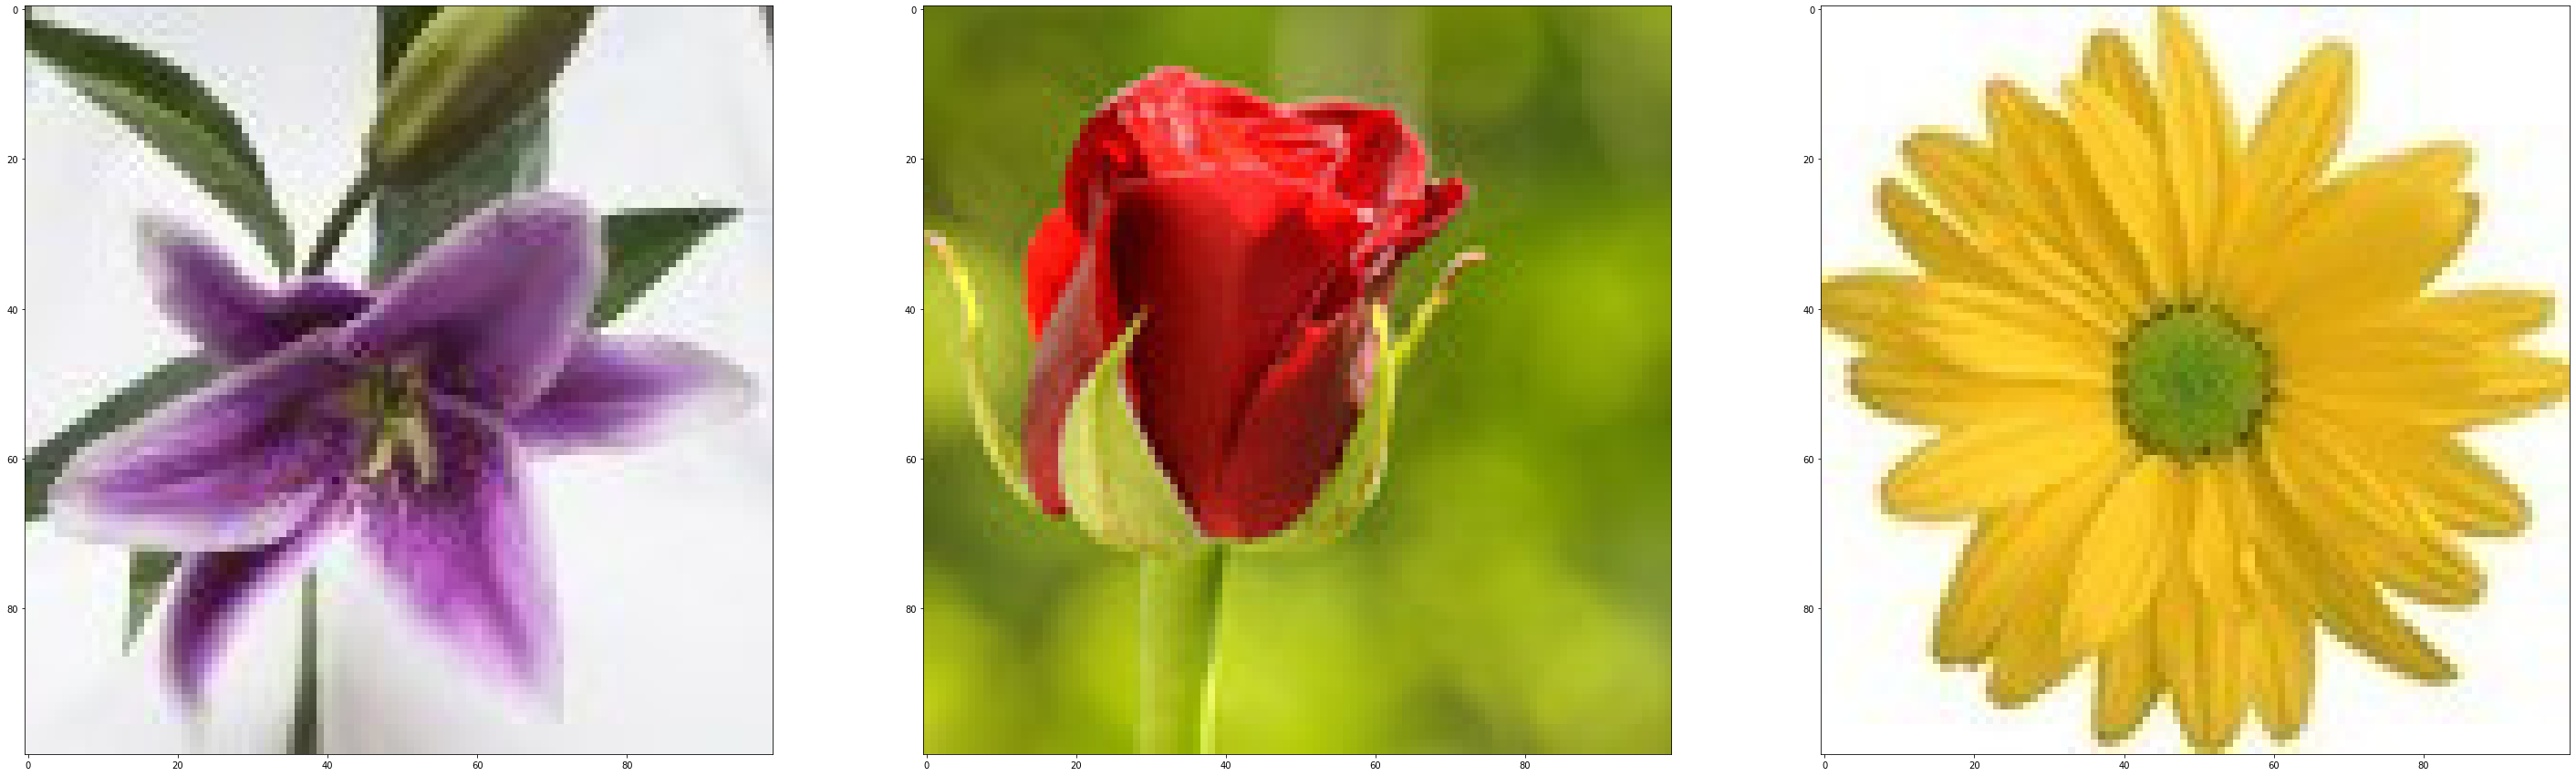

In [ ]:
#Выводим тестовые картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(50, 50)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем изображениям
  flowers_path = '/content/Flowers_test/' + os.listdir(test_path)[i] #Формируем путь к каждому цветочку
  axs[i].imshow(image.load_img(flowers_path, target_size=(img_height, img_width))) #Отображение цветок

plt.show() #Показываем изображения

Создаем REST запрос

Создаем JSON объект для batch-а 3х инференс-запросов и посмотрим, насколько хорошо модель распознает цветы

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]]}




Пошлем запрос с помощью POST и посмотрим на работу модели

In [ ]:
!pip install -q requests

import requests

Выбираем конкретную servable\обслуживаемую модель

выбираем версию 1, так как она самая "умная"

In [ ]:
# Функция для просмотра картинки из сета
def show(x_test, idx, title):
  plt.figure()
  plt.imshow(x_test[idx])
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 14})

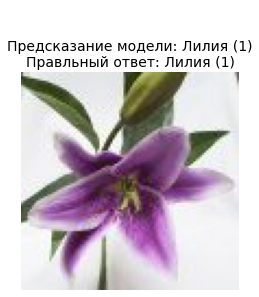

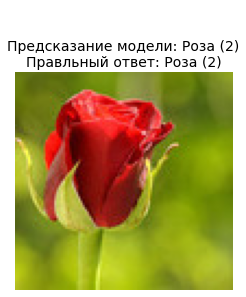

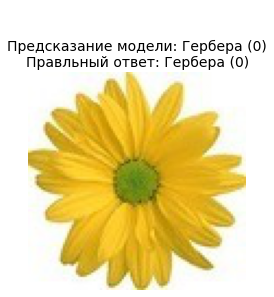

In [ ]:
headers = {"content-type": "application/json"} # здесь вы по сути объявляете формат объекта со всей ифной по инференсу. Строчка с content-type  обязательна
json_response = requests.post('http://localhost:8501/v1/models/model/versions/1:predict', data=data, headers=headers) # /versions/1: вот эта часть отвечает за выбор модели
predictions = json.loads(json_response.text)['predictions']

for i in range(3):
  show(x_test, i,
       'Предсказание модели: {} ({})\nПравльный ответ: {} ({})'
       .format(classes[np.argmax(predictions[i])], np.argmax(predictions[i]),
               classes[y_test[i][0]], y_test[i][0]))

Видем что модель хорошо справилась, все три цветочка распознались

Сохраняем модель и предикт, чтобы иметь возможность запускать локально

In [ ]:
!zip -r '/content/model.zip' '/content/our_models1'

  adding: content/our_models1/ (stored 0%)
  adding: content/our_models1/1/ (stored 0%)
  adding: content/our_models1/1/assets/ (stored 0%)
  adding: content/our_models1/1/variables/ (stored 0%)
  adding: content/our_models1/1/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/our_models1/1/variables/variables.index (deflated 75%)
  adding: content/our_models1/1/saved_model.pb (deflated 90%)
  adding: content/our_models1/2/ (stored 0%)
  adding: content/our_models1/2/assets/ (stored 0%)
  adding: content/our_models1/2/variables/ (stored 0%)
  adding: content/our_models1/2/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/our_models1/2/variables/variables.index (deflated 75%)
  adding: content/our_models1/2/saved_model.pb (deflated 90%)


In [ ]:
json_file = open('predict.json', 'w')
json_file.write(data)
json_file.close()

Вот они 3 созданные версии:

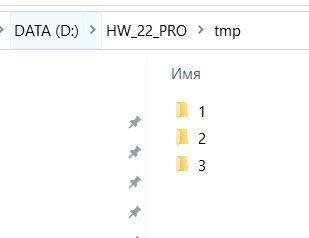

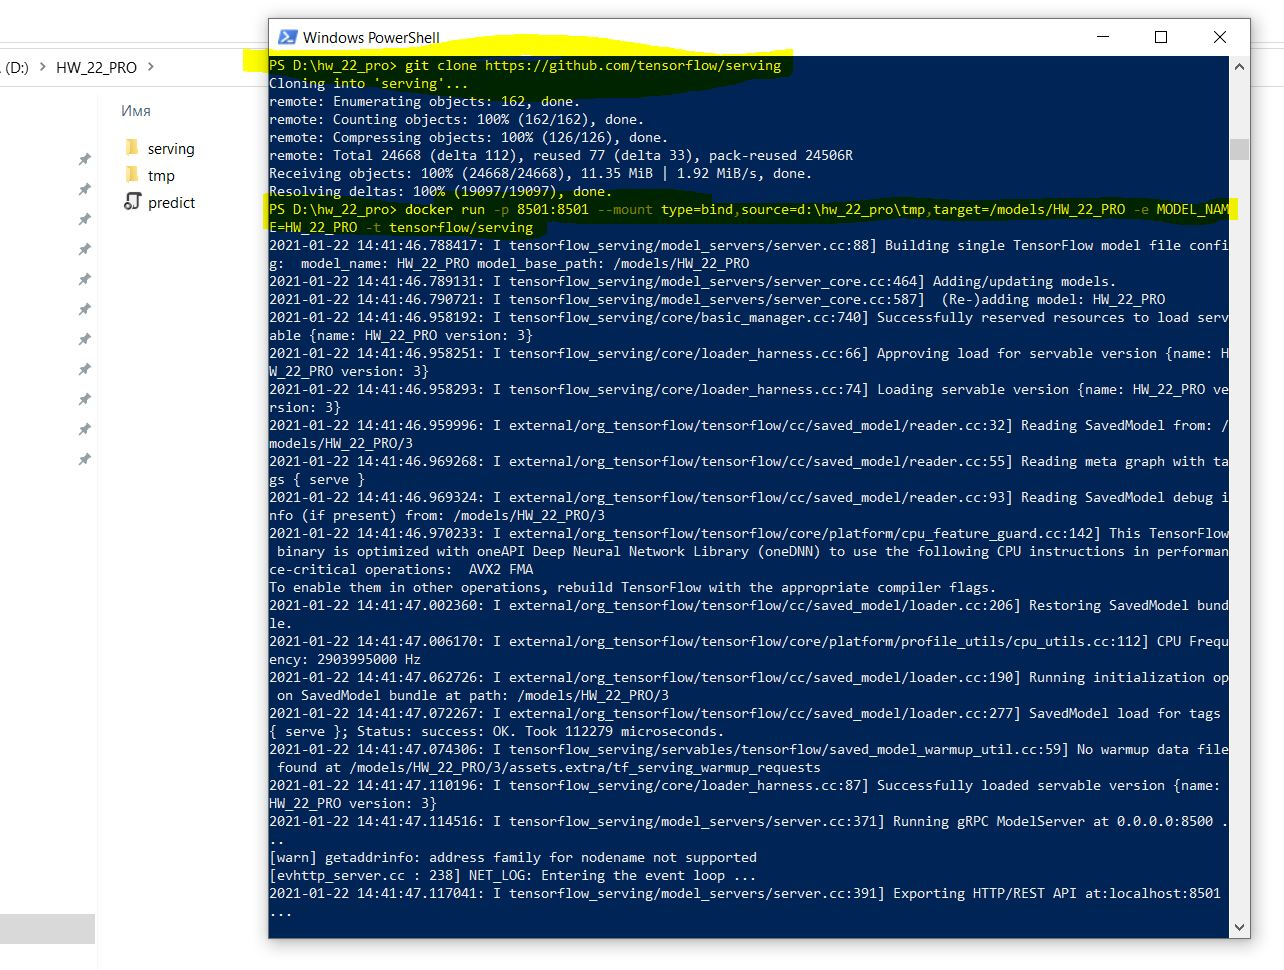

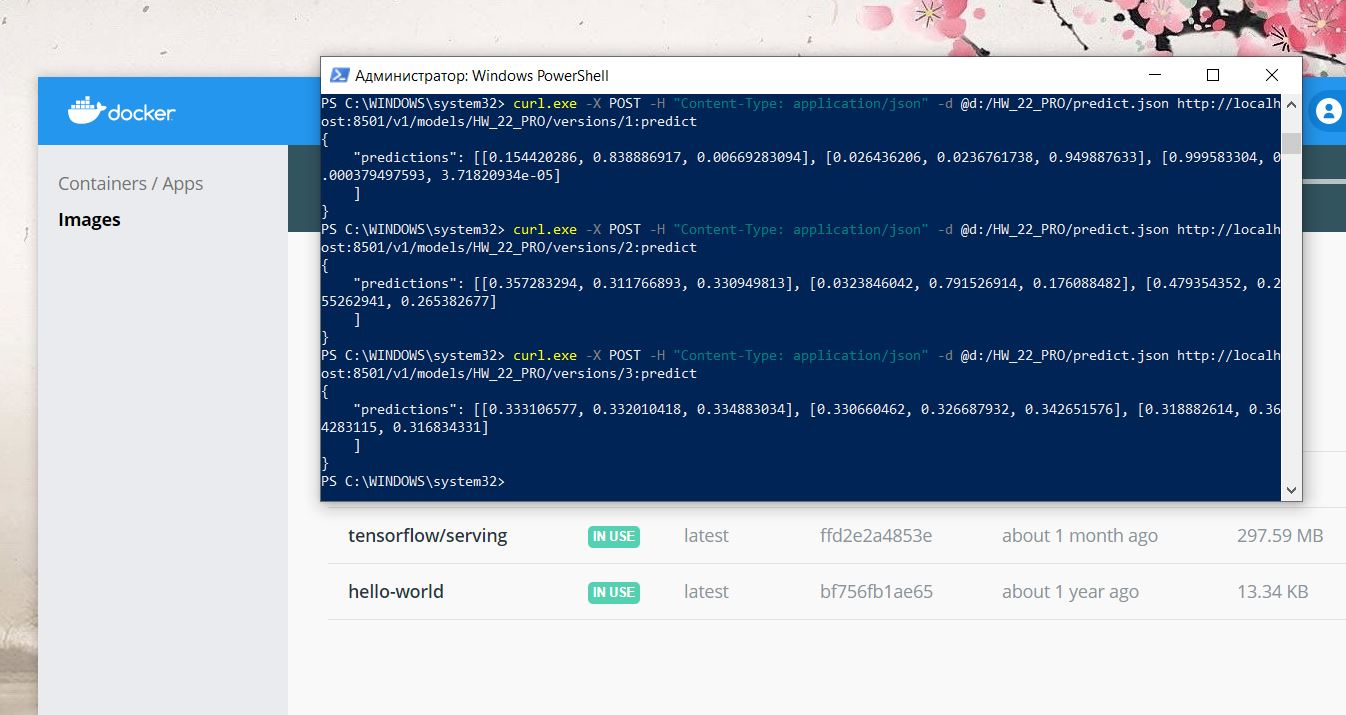

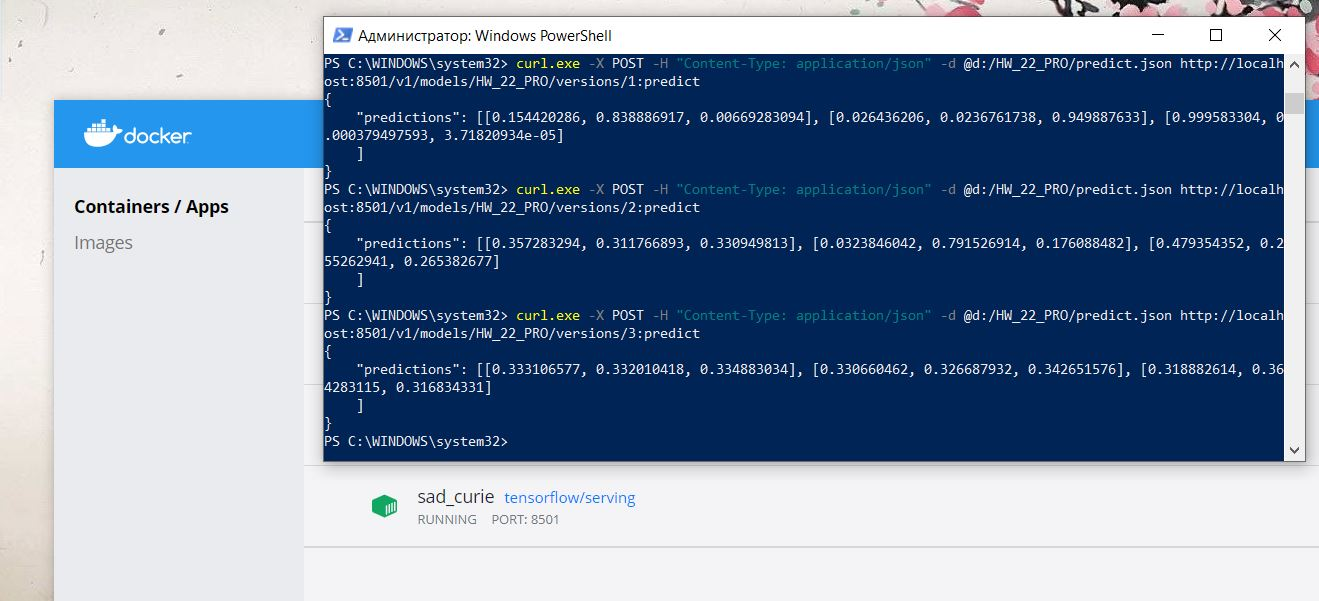

#### 5) Посмотрите каким будет предсказание для разных версий, используя запросы на сервер.

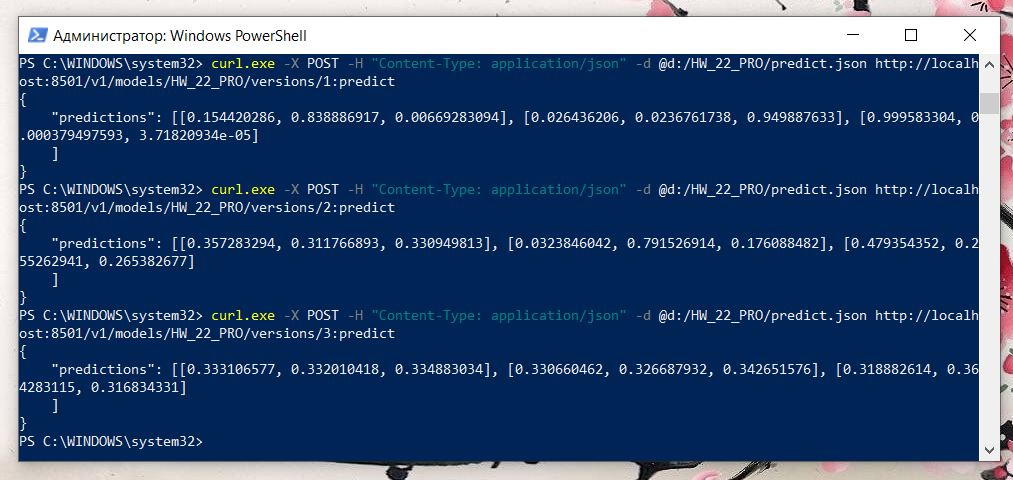

Скопируем ответы(предикты) из консоли в Colab

**PS C:\WINDOWS\system32> curl.exe -X POST -H "Content-Type: application/json" -d @d:/HW_22_PRO/predict.json http://localhost:8501/v1/models/HW_22_PRO/versions/1:predict**

{
    "predictions": [[0.154420286, **0.838886917**, 0.00669283094], [0.026436206, 0.0236761738, **0.949887633**], [**0.999583304**, 0.000379497593, 3.71820934e-05]
    ]
}


**PS C:\WINDOWS\system32> curl.exe -X POST -H "Content-Type: application/json" -d @d:/HW_22_PRO/predict.json http://localhost:8501/v1/models/HW_22_PRO/versions/2:predict**

{
    "predictions": [[**0.357283294**, 0.311766893, 0.330949813], [0.0323846042, **0.791526914**, 0.176088482], [**0.479354352**, 0.255262941, 0.265382677]
    ]
}

**PS C:\WINDOWS\system32> curl.exe -X POST -H "Content-Type: application/json" -d @d:/HW_22_PRO/predict.json http://localhost:8501/v1/models/HW_22_PRO/versions/3:predict**

{
    "predictions": [[0.333106577, 0.332010418, **0.334883034**], [0.330660462, 0.326687932, **0.342651576**], [0.318882614, **0.364283115**, 0.316834331]
    ]
}

**Протестируем результаты**

##### Версия 1

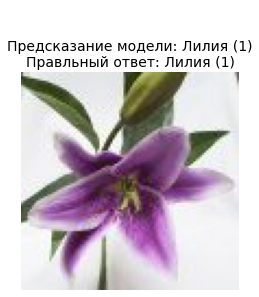

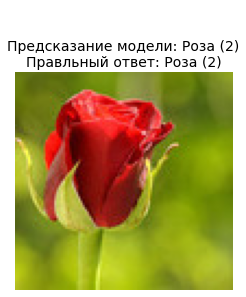

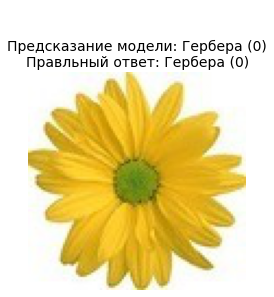

In [ ]:
predictions = json.loads('{ "predictions": [[0.154420286, 0.838886917, 0.00669283094], [0.026436206, 0.0236761738, 0.949887633], [0.999583304, 0.000379497593, 3.71820934e-05] ] }')['predictions']

for i in range(3):
  show(x_test, i,
       'Предсказание модели: {} ({})\nПравльный ответ: {} ({})'
       .format(classes[np.argmax(predictions[i])], np.argmax(predictions[i]),
               classes[y_test[i][0]], y_test[i][0]))

Как видим 1я версия модели(самая "умная") справилась отлично, верно распознав 3 из 3 цветков!

##### Версия 2

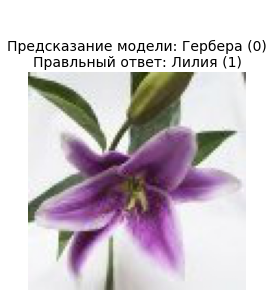

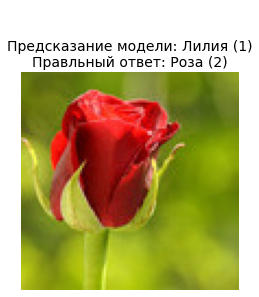

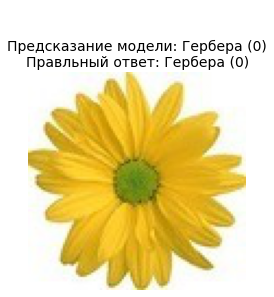

In [ ]:
predictions = json.loads('{ "predictions": [[0.357283294, 0.311766893, 0.330949813], [0.0323846042, 0.791526914, 0.176088482], [0.479354352, 0.255262941, 0.265382677] ] }')['predictions']

for i in range(3):
  show(x_test, i,
       'Предсказание модели: {} ({})\nПравльный ответ: {} ({})'
       .format(classes[np.argmax(predictions[i])], np.argmax(predictions[i]),
               classes[y_test[i][0]], y_test[i][0]))

2я версия показала плохой результат, правильно распознав только 1 цветок из 3х. Но большего от нее и не ожидалось.

##### Версия 3

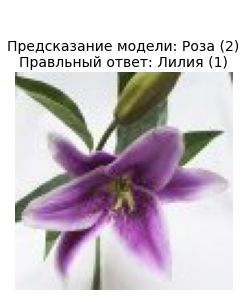

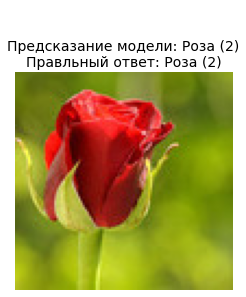

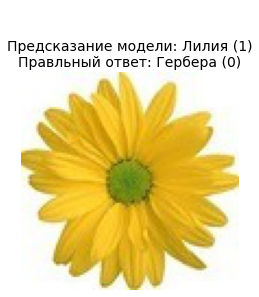

In [ ]:
predictions = json.loads('{ "predictions": [[0.333106577, 0.332010418, 0.334883034], [0.330660462, 0.326687932, 0.342651576], [0.318882614, 0.364283115, 0.316834331] ] }')['predictions']

for i in range(3):
  show(x_test, i,
       'Предсказание модели: {} ({})\nПравльный ответ: {} ({})'
       .format(classes[np.argmax(predictions[i])], np.argmax(predictions[i]),
               classes[y_test[i][0]], y_test[i][0]))

3я версия самая "глупенькая" которая была сосдана для тренировки создания версий показала совсем плохой результат... хоть и распазнала верно 1 цветок, но все вероятности практически одинаковые варьируюься около цифры 0.33.

#### **Выводы:**

Результат получился именно таким каким и ожидался. Хорошо обученная модель дала отличный результат разпознав все верно, простенькая плохо обученная модель распазнала 1 из 3, но вероятности всетаки не одинаковые как у 3й версии. 3я самая необученная "глупенькая модель" показала очень плохой результат. 

Итоговый результат можно считать очень хорошим!
